# Trabalho 02

Link dataset: https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis?select=twitter_training.csv

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Monitoramento de recursos

In [2]:
import sys

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def print_top_mem_vars(variables):
    """Usage:
    mem.print_top_mem_vars(locals())
    mem.print_top_mem_vars(globals())
    """
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in variables.items()), key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

## Importação dos dados

In [3]:
df = pd.read_csv('sentiment_menssage.csv')

## Análise dos dados

In [4]:
df.head()

,sentiment,message
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df.shape

(75682, 2)

In [6]:
df.describe()

,sentiment,message
count,75682,74996
unique,4,69974
top,Negative,"At the same time, despite the fact that there ..."
freq,22808,172


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   message    74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


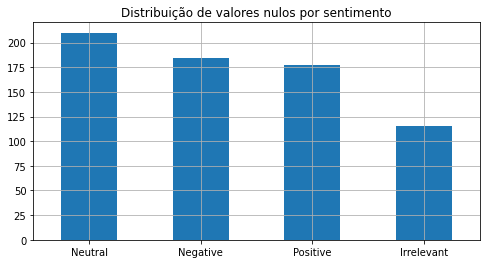

In [8]:
df[df['message'].isnull()]['sentiment'].value_counts()\
    .plot.bar(rot=0, 
              grid=True,
              title='Distribuição de valores nulos por sentimento',
              figsize=(8,4));

In [9]:
print('Total de descrições nulas:', len(df['message'].isnull()))

Total de descrições nulas: 75682


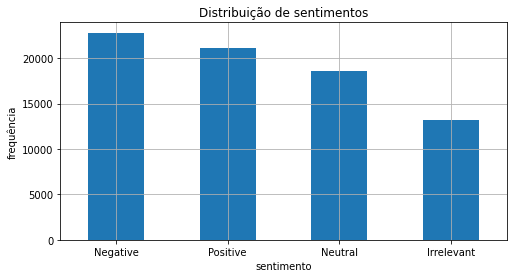

In [10]:
df['sentiment'].value_counts()\
    .plot.bar(rot=0, 
              grid=True, 
              title='Distribuição de sentimentos', 
              xlabel='sentimento', 
              ylabel='frequência',
              figsize=(8,4));

## Pré-processamento

In [11]:
# !pip install gensim

In [12]:
import re

import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Remoção de emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

In [14]:
df.dropna(subset=['message'], inplace=True)

In [15]:
stop_words = stopwords.words('english')

def removing_unwanted_characters(text: str):
    text = emoji_pattern.sub(r'', text) # Remoção de emoji
    text = re.sub(r'[0-9]+', ' ', text) # Remoção de numeros
    text = text.lower().replace('’', '')
    text = re.sub(r'["-,.:@#?!&$]',' ', text)
    text = re.sub(r"^\s+|\s+$", "", text)
    return ' '.join([word for word in text.split() if word not in stop_words])

In [16]:
df['message'] = df.message.map(removing_unwanted_characters)

In [17]:
map_replace = {'sentiment': {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}}
df = df.replace(map_replace)

In [18]:
print_top_mem_vars(locals())
print('\n')
print_top_mem_vars(globals())

                            df: 11.2 MiB
                          _i13:  2.1 KiB
                    stop_words:  1.6 KiB
                          _iii:  1.3 KiB
                          _i15:  1.3 KiB
               CountVectorizer:  1.0 KiB
               TfidfVectorizer:  1.0 KiB
                           ___: 1016.0 B
                            _4: 1016.0 B
                             _:  874.0 B


                            df: 11.2 MiB
                          _i13:  2.1 KiB
                    stop_words:  1.6 KiB
                          _iii:  1.3 KiB
                          _i15:  1.3 KiB
               CountVectorizer:  1.0 KiB
               TfidfVectorizer:  1.0 KiB
                           ___: 1016.0 B
                            _4: 1016.0 B
                             _:  874.0 B


In [19]:
del stop_words, emoji_pattern

In [20]:
text_representation = {
    'CountVectorizer': CountVectorizer(),
    'TfidfVectorizer': TfidfVectorizer()
}

## Uso de modelos preditivos para obtenção de predições (classificações / regressões)

- Usar Grid Search e Validação Cruzada com k-Fold.
- Usar os algoritmos aprendidos na disciplina, incluindo: kNN, SVM, Árvore de Decisão, Random Forest, Gradient Boosting e Redes Neurais.
- Avaliação dos resultados através de métricas

In [97]:
from statistics import mean
import time

# Separação treino e teste
from sklearn.model_selection import train_test_split

# Algoritmos de classificação
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Redes neurais
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

# Validação Cruzada com kFold
from sklearn.model_selection import cross_val_score, KFold

# Grid Search
from sklearn.model_selection import GridSearchCV

# Pipele models
from sklearn.pipeline import Pipeline

# Métricas de avaliação
from sklearn.metrics import accuracy_score, f1_score

### Separação de treino e teste

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['sentiment'], test_size=.3, stratify=df['sentiment'], random_state=42)

### Busca do melhor algoritmo

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
models = {
    'KNN': KNeighborsClassifier(),
    'SVM': LinearSVC(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(max_iter=300, random_state=42),
    'Perceptron': Perceptron(tol=1e-3, random_state=42)
}

In [25]:
result = {
    'models': [],
    'text_representation': [],
    'f1_score': []
}

In [26]:
start = time.time()
for name_representation, representation in text_representation.items():
    X_train_text = representation.fit_transform(X_train)
    for name_model, model in models.items():
        print(name_representation, name_model)
        result['models'].append(name_model)
        result['text_representation'].append(name_representation)
        result['f1_score'].append(cross_val_score(model, X_train_text, y_train, cv=kfold, scoring='f1_weighted'))
        del model
    del X_train_text

end = time.time()

print('Tempo de execução:', end-start)

CountVectorizer KNN
CountVectorizer SVM
CountVectorizer DecisionTree
CountVectorizer RandomForest
CountVectorizer GradientBoosting
CountVectorizer MLPClassifier
CountVectorizer Perceptron
TfidfVectorizer KNN
TfidfVectorizer SVM
TfidfVectorizer DecisionTree
TfidfVectorizer RandomForest
TfidfVectorizer GradientBoosting
TfidfVectorizer MLPClassifier
TfidfVectorizer Perceptron
Tempo de execução: 27904.224339723587


In [27]:
pd.DataFrame(result).sort_values('f1_score', ascending=False)

,models,text_representation,f1_score
10,RandomForest,TfidfVectorizer,0.887354
3,RandomForest,CountVectorizer,0.882139
12,MLPClassifier,TfidfVectorizer,0.865385
5,MLPClassifier,CountVectorizer,0.848118
8,SVM,TfidfVectorizer,0.842742
1,SVM,CountVectorizer,0.836390
13,Perceptron,TfidfVectorizer,0.815622
6,Perceptron,CountVectorizer,0.814710
2,DecisionTree,CountVectorizer,0.794217
7,KNN,TfidfVectorizer,0.791543


In [28]:
pd.DataFrame(result).sort_values('f1_score').to_csv('result.csv', index=False)

### Busca dos melhores hiper-paramentros

In [143]:
%%time
parameters = { 
    'RandomForest__n_estimators': [100, 200, 500, 700, 1000],
    'RandomForest__max_features': ['auto', 'sqrt', 'log2'],
    'RandomForest__max_depth': [4, 6, 8, 10]
}

rf = GridSearchCV(
    Pipeline([
        ('TfidfVectorizer', TfidfVectorizer()),
        ('RandomForest', RandomForestClassifier(random_state=42))
    ]), 
    parameters,
    n_jobs=-1,
    cv=kfold,
    scoring='f1_weighted',
)

rf.fit(X_train, y_train)

print('Melhor f1:', rf.best_score_)
print('Melhor modelo:', rf.best_estimator_)

Melhor f1: 0.3847740812554605
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('RandomForest',
                 RandomForestClassifier(max_depth=10, n_estimators=500,
                                        random_state=42))])
CPU times: user 21.7 s, sys: 937 ms, total: 22.7 s
Wall time: 9min 28s


### Algoritmos proposto

In [144]:
model = rf.best_estimator_

model.fit(X_train, y_train)

y_pred = model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average='weighted')
print(f"Treino - Accuracy: {acc}, F1: {f1}")

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Teste - Accuracy: {acc}, F1: {f1}")

Treino - Accuracy: 0.46581709431015106, F1: 0.39692157534062444
Teste - Accuracy: 0.45130894706431396, F1: 0.38093635288429645


# Experimento 02 - Amostragem

<div style="background:#f3f3f3; ">
    <br>
    <center>
        <img  src="https://latex.codecogs.com/png.image?\Large&space;n \approx \frac{p}{\frac{4\cdot(p - 1)\cdot err^2}{Z^2} + 1}" title="\Large n \approx \frac{pop}{\frac{4\cdot(pop - 1)\cdot err^2}{Z^2} + 1}" />
    <\center>
    <br>
<\div>

n = Tamanho da amostra <br>
p = População <br>
err = Margem de erro (%) <br>
Z = z_score

In [50]:
import math
def amostragem(p, err, c):
    Z = {0.90: 1.65, 0.95: 1.96, 0.99: 2.58}
    n = math.ceil( p / ( ( 4*(p - 1)*math.pow(err,2)/math.pow(Z[c],2) ) + 1 ) )
    return n

In [77]:
p = df.shape[0]
err = .02
c = 0.99
n = amostragem(p, err, c)
print(
f'''
População: {p}
Margem de erro: {err*100}%
Confiabilidade: {c*100}%
Tamanho da amostra: {n}
'''
)


População: 74996
Margem de erro: 2.0%
Confiabilidade: 99.0%
Tamanho da amostra: 3942



In [78]:
sample = df.sample(n, weights='sentiment', random_state=42)

In [79]:
X_sample, y_sample = sample['message'], sample['sentiment']

In [80]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [101]:
result_gridSearch = {
    'best_pipeline_model': [],
    'f1_score': []
}

text_representation = ['CountVectorizer', 'TfidfVectorizer']

### KNeighborsClassifier

In [134]:
%%time
parameters = {
    "knn__weights": ["uniform", "distance"],
    "knn__n_neighbors": [3, 5, 7, 9, 11]
}

for text_r in text_representation:
    knn = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('knn', KNeighborsClassifier())
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_weighted',
    )

    knn.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(knn.best_estimator_)
    result_gridSearch['f1_score'].append(knn.best_score_)

    print('Melhor f1:', knn.best_score_)
    print('Melhor modelo:', knn.best_estimator_)
    del knn

Melhor f1: 0.521416111312776
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])
Melhor f1: 0.4895483444963915
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(weights='distance'))])
CPU times: user 221 ms, sys: 675 ms, total: 896 ms
Wall time: 4.95 s


### LinearSVC

In [135]:
%%time
parameters = {
    "svm__C": [0.001, 0.01, 0.1, 1.],
    "svm__penalty": ['l1', 'l2']
}


for text_r in text_representation:
    svm = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('svm', LinearSVC(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_weighted',
    )

    svm.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(svm.best_estimator_)
    result_gridSearch['f1_score'].append(svm.best_score_)

    print('Melhor f1:', svm.best_score_)
    print('Melhor modelo:', svm.best_estimator_)
    del svm

Melhor f1: 0.6710610261885308
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('svm', LinearSVC(C=0.1, random_state=42))])
Melhor f1: 0.6755187163547067
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('svm', LinearSVC(random_state=42))])
CPU times: user 168 ms, sys: 432 ms, total: 599 ms
Wall time: 2.14 s


### DecisionTreeClassifier

In [136]:
%%time
parameters = {
    'dt__criterion':['gini', 'entropy'],
    "dt__max_depth": [3, 5, 7, 9, 11, 13],
}

for text_r in text_representation:
    dt = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('dt', DecisionTreeClassifier(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_weighted',
    )

    dt.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(dt.best_estimator_)
    result_gridSearch['f1_score'].append(dt.best_score_)

    print('Melhor f1:', dt.best_score_)
    print('Melhor modelo:', dt.best_estimator_)
    del dt

Melhor f1: 0.5439974503905919
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=13,
                                        random_state=42))])
Melhor f1: 0.5144670648931168
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier(max_depth=13, random_state=42))])
CPU times: user 752 ms, sys: 0 ns, total: 752 ms
Wall time: 3.29 s


### RandomForestClassifier

In [137]:
%%time
parameters = { 
    'rf__n_estimators': [100, 200, 500],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [4, 6, 8]
}

for text_r in text_representation:
    rf = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('rf', RandomForestClassifier(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_weighted',
    )

    rf.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(rf.best_estimator_)
    result_gridSearch['f1_score'].append(rf.best_score_)

    print('Melhor f1:', rf.best_score_)
    print('Melhor modelo:', rf.best_estimator_)
    del rf

Melhor f1: 0.36882087242584116
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('rf', RandomForestClassifier(max_depth=8, random_state=42))])
Melhor f1: 0.37241108745779833
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('rf',
                 RandomForestClassifier(max_depth=8, n_estimators=200,
                                        random_state=42))])
CPU times: user 2.3 s, sys: 0 ns, total: 2.3 s
Wall time: 39.9 s


### GradientBoostingClassifier

In [138]:
%%time
parameters = {
    "gb__learning_rate": [0.01, 0.1, 0.2],
    "gb__min_samples_split": np.linspace(0.1, 0.5, 5),
    "gb__min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "gb__max_depth": [3, 5, 8],
    "gb__subsample": [0.5, 0.8, 1.0],
    "gb__n_estimators":[10]
}

for text_r in text_representation:
    gb = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('gb', GradientBoostingClassifier(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_weighted',
    )

    gb.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(gb.best_estimator_)
    result_gridSearch['f1_score'].append(gb.best_score_)

    print('Melhor f1:', gb.best_score_)
    print('Melhor modelo:', gb.best_estimator_)
    del gb

Melhor f1: 0.442430055926953
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('gb',
                 GradientBoostingClassifier(min_samples_leaf=0.1,
                                            min_samples_split=0.1,
                                            n_estimators=10, random_state=42,
                                            subsample=0.8))])
Melhor f1: 0.44226042619063766
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('gb',
                 GradientBoostingClassifier(min_samples_leaf=0.1,
                                            min_samples_split=0.1,
                                            n_estimators=10, random_state=42,
                                            subsample=0.8))])
CPU times: user 38.2 s, sys: 2.52 s, total: 40.7 s
Wall time: 4min 22s


### MLPClassifier

In [117]:
%%time
parameters = {
    'mpl__solver': ['lbfgs'], 
    'mpl__max_iter': [1000, 1500, 2000], 
    'mpl__alpha': 10.0 ** -np.arange(1, 3), 
    'mpl__hidden_layer_sizes': [10, 14]
}

for text_r in text_representation:
    mpl = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('mpl', MLPClassifier(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_macro',
    )

    mpl.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(mpl.best_estimator_)
    result_gridSearch['f1_score'].append(mpl.best_score_)

    print('Melhor f1:', mpl.best_score_)
    print('Melhor modelo:', mpl.best_estimator_)
    del mpl

Melhor f1: 0.6153841309178932
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('mpl',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=12, max_iter=1000,
                               random_state=42, solver='lbfgs'))])
Melhor f1: 0.6179189573650226
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('mpl',
                 MLPClassifier(alpha=0.1, hidden_layer_sizes=10, max_iter=1000,
                               random_state=42, solver='lbfgs'))])
CPU times: user 2min 41s, sys: 6min 46s, total: 9min 28s
Wall time: 43min 46s


### Perceptron

In [119]:
%%time
parameters = {
    'perc__alpha': [0.0001, 0.001, 0.01, 0.1],
    'perc__eta0': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'perc__max_iter': [1, 10, 100, 1000, 10000]
}

for text_r in text_representation:
    perc = GridSearchCV(
        Pipeline([
            (text_r, eval(text_r)()),
            ('perc', Perceptron(random_state=42))
        ]), 
        parameters,
        n_jobs=-1,
        cv=kfold,
        scoring='f1_macro',
    )

    perc.fit(X_sample, y_sample)
    
    result_gridSearch['best_pipeline_model'].append(perc.best_estimator_)
    result_gridSearch['f1_score'].append(perc.best_score_)

    print('Melhor f1:', perc.best_score_)
    print('Melhor modelo:', perc.best_estimator_)
    del perc

Melhor f1: 0.6143829368817615
Melhor modelo: Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('perc', Perceptron(eta0=0.001, max_iter=10, random_state=42))])
Melhor f1: 0.6165138591549469
Melhor modelo: Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('perc', Perceptron(eta0=0.001, max_iter=10, random_state=42))])
CPU times: user 4.83 s, sys: 0 ns, total: 4.83 s
Wall time: 19.6 s


## Resultados

In [133]:
pd.DataFrame(result_gridSearch).sort_values('f1_score', ascending=False).to_csv('result_amostragem.csv', index=False)

In [122]:
pd.DataFrame(result_gridSearch).sort_values('f1_score', ascending=False)

,best_pipeline_model,f1_score
3,"(TfidfVectorizer(), LinearSVC(random_state=42))",0.636484
2,"(CountVectorizer(), LinearSVC(C=0.1, random_st...",0.631415
11,"(TfidfVectorizer(), MLPClassifier(alpha=0.1, h...",0.617919
13,"(TfidfVectorizer(), Perceptron(eta0=0.001, max...",0.616514
10,"(CountVectorizer(), MLPClassifier(alpha=0.01, ...",0.615384
12,"(CountVectorizer(), Perceptron(eta0=0.001, max...",0.614383
4,"(CountVectorizer(), DecisionTreeClassifier(cri...",0.472358
0,"(CountVectorizer(), KNeighborsClassifier(n_nei...",0.469227
1,"(TfidfVectorizer(), KNeighborsClassifier(weigh...",0.441283
5,"(TfidfVectorizer(), DecisionTreeClassifier(max...",0.436281


## Algoritmo proposto

In [142]:
model = pd.DataFrame(result_gridSearch).sort_values('f1_score', ascending=False).iloc[0].best_pipeline_model

model.fit(X_train, y_train)

y_pred = model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average='weighted')
print(f"Treino - Accuracy: {acc}, F1: {f1}")

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Teste - Accuracy: {acc}, F1: {f1}")

Treino - Accuracy: 0.9273482294226337, F1: 0.9274474161893308
Teste - Accuracy: 0.8621272056535846, F1: 0.8620739535838985
